In [2]:
import os
import cv2
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import keras
from keras.layers import Input
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Phase 1: Dataset Preparation

In [10]:
# dataset_path = '/Users/maheshnilewar/Documents/Github/image_classification/TinyImageNet100'
# output_path = '/Users/maheshnilewar/Documents/Github/image_classification/dataset'

# def prepare_dataset(dataset_path, output_path, num_classes=15):
#     os.makedirs(output_path, exist_ok=True)
    
#     # Getting all class folders and selected classes
#     class_folders = sorted(os.listdir(dataset_path))
#     selected_classes = random.sample(class_folders, num_classes)
    
#     # Keep selected classes labeled the same.
#     with open(os.path.join(output_path, "class_labels.txt"), "w") as f:
#         for i, cls in enumerate(selected_classes):
#             f.write(f"{cls},{i}\n")
    
#     for cls in selected_classes:
#         # Collect all images for the class.
#         class_images_path = os.path.join(dataset_path, cls, "images")
#         images = sorted(os.listdir(class_images_path))

#         if not os.path.isdir(class_images_path):  # Skip if not a directory
#             print(f"Skipping: {class_images_path} (Not a directory)")
#             continue

#         # Separating training and testing images
#         training_images = images[:400]
#         testing_images = images[400:500]

#         # Save training images
#         train_dir = os.path.join(output_path, "train", cls)
#         os.makedirs(train_dir, exist_ok=True)
#         for img in training_images:
#             os.link(os.path.join(class_images_path, img), os.path.join(train_dir, img))

#         # Save testing images
#         test_dir = os.path.join(output_path, "test", cls)
#         os.makedirs(test_dir, exist_ok=True)
#         for img in testing_images:
#             os.link(os.path.join(class_images_path, img), os.path.join(test_dir, img))

#     print(f"Dataset with {num_classes} classes prepared at: {output_path}")

# prepare_dataset(dataset_path, output_path, num_classes=15)

# def load_images(folder_path, class_labels_file):
#     images, labels, image_paths = [], [], []
    
#     # Read class label mappings.
#     label_map = {}
#     with open(class_labels_file, "r") as f:
#         for line in f:
#             class_name, label = line.strip().split(",")
#             label_map[class_name] = int(label)
    
#     for class_name, label in label_map.items():
#         class_folder = os.path.join(folder_path, class_name)
#         if os.path.isdir(class_folder):
#             for img_name in os.listdir(class_folder):
#                 img_path = os.path.join(class_folder, img_name)
#                 if img_path.lower().endswith(('.jpg', '.png', '.jpeg')):
#                     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#                     if img is not None:
#                         images.append(img)
#                         labels.append(label)
    
#     return images, np.array(labels)

# # Load train and test images
# train_path = os.path.join(output_path, "train")
# test_path = os.path.join(output_path, "test")
# class_labels_file = os.path.join(output_path, "class_labels.txt")

# train_images, train_labels = load_images(train_path, class_labels_file)
# test_images, test_labels = load_images(test_path, class_labels_file)

# print(f"Loaded {len(train_images)} training images and {len(test_images)} test images.")
import os
import random
import cv2
import numpy as np

dataset_path = '/Users/maheshnilewar/Documents/Github/image_classification/TinyImageNet100'
output_path  = '/Users/maheshnilewar/Documents/Github/image_classification/dataset'

def prepare_dataset(dataset_path, output_path, num_classes=15, seed=42):
    random.seed(seed)
    os.makedirs(output_path, exist_ok=True)

    # Only take real directories (ignore .DS_Store, hidden files, etc.)
    class_folders = sorted([
        d for d in os.listdir(dataset_path)
        if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith(".")
    ])

    selected_classes = random.sample(class_folders, num_classes)

    # Save label mapping
    with open(os.path.join(output_path, "class_labels.txt"), "w") as f:
        for i, cls in enumerate(selected_classes):
            f.write(f"{cls},{i}\n")

    for cls in selected_classes:
        class_images_path = os.path.join(dataset_path, cls, "images")

        # Check before listdir
        if not os.path.isdir(class_images_path):
            print(f"Skipping: {class_images_path} (Not a directory)")
            continue

        images = sorted([
            img for img in os.listdir(class_images_path)
            if not img.startswith(".")  # ignore .DS_Store inside images folder too
        ])

        training_images = images[:400]
        testing_images  = images[400:500]

        train_dir = os.path.join(output_path, "train", cls)
        test_dir  = os.path.join(output_path, "test", cls)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        for img in training_images:
            src = os.path.join(class_images_path, img)
            dst = os.path.join(train_dir, img)
            if not os.path.exists(dst):
                os.link(src, dst)

        for img in testing_images:
            src = os.path.join(class_images_path, img)
            dst = os.path.join(test_dir, img)
            if not os.path.exists(dst):
                os.link(src, dst)

    print(f"Dataset with {num_classes} classes prepared at: {output_path}")

prepare_dataset(dataset_path, output_path, num_classes=15)

def load_images(folder_path, class_labels_file):
    images, labels = [], []

    label_map = {}
    with open(class_labels_file, "r") as f:
        for line in f:
            class_name, label = line.strip().split(",")
            label_map[class_name] = int(label)

    for class_name, label in label_map.items():
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for img_name in os.listdir(class_folder):
            if img_name.startswith("."):
                continue
            img_path = os.path.join(class_folder, img_name)
            if img_path.lower().endswith(('.jpg', '.png', '.jpeg')):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    labels.append(label)

    return images, np.array(labels)

Dataset with 15 classes prepared at: /Users/maheshnilewar/Documents/Github/image_classification/dataset


# Phase 2: Conduct image classification using the hand-crafted feature approach

Bag of Words (BoW) model using ORB (Oriented FAST and rotated BRIEF) features

Train images: 6000 | Test images: 1500
Num classes: 15
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       100
           1     0.0943    0.0500    0.0654       100
           2     0.0571    0.0200    0.0296       100
           3     0.0909    0.0100    0.0180       100
           4     0.0930    0.0400    0.0559       100
           5     0.1818    0.0200    0.0360       100
           6     0.0455    0.0100    0.0164       100
           7     0.0833    0.0100    0.0179       100
           8     0.0000    0.0000    0.0000       100
           9     0.0000    0.0000    0.0000       100
          10     0.0691    0.8300    0.1276       100
          11     0.1765    0.0300    0.0513       100
          12     0.0909    0.0200    0.0328       100
          13     0.0000    0.0000    0.0000       100
          14     0.0612    0.0300    0.0403       100

    accuracy                         0.0713      1500
   macro avg     0.0696  

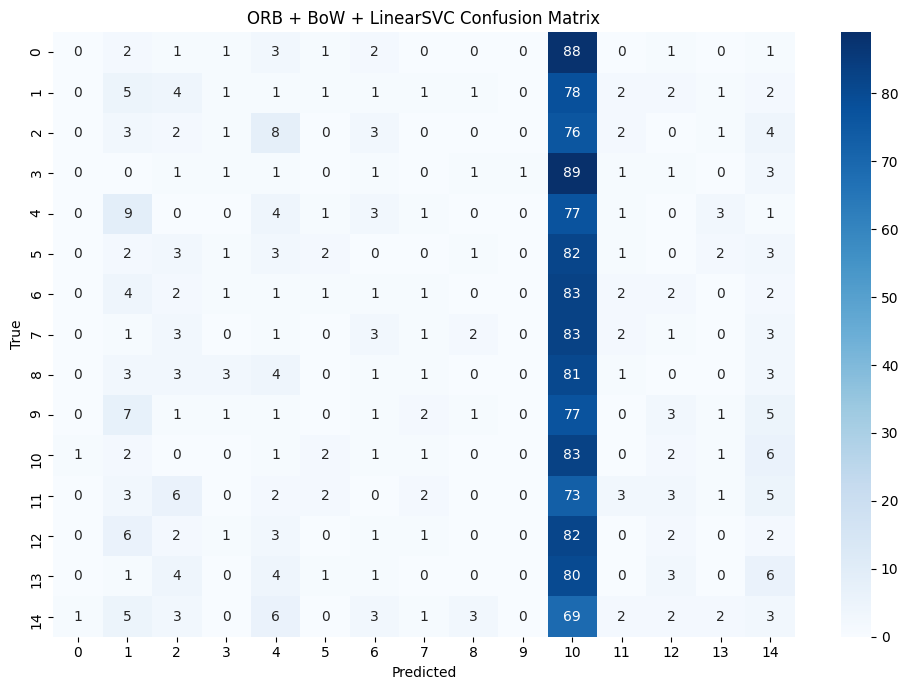


Saved outputs to:
 - /Users/maheshnilewar/Documents/Github/image_classification/results/metrics/orb_bow_linearsvc_k100_nf500_classification_report.txt
 - /Users/maheshnilewar/Documents/Github/image_classification/results/metrics/orb_bow_linearsvc_k100_nf500_summary.json
 - /Users/maheshnilewar/Documents/Github/image_classification/results/metrics/orb_bow_linearsvc_k100_nf500_confusion_matrix.csv
 - /Users/maheshnilewar/Documents/Github/image_classification/results/figures/orb_bow_linearsvc_k100_nf500_confusion_matrix.png


In [16]:
# =========================
# ORB + BoW + LinearSVC
# Save outputs to your results location
# =========================

import os
import json
import cv2
import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


# --------- INPUT PATHS ----------
# output_path should contain: train/, test/, class_labels.txt
# Example:
# output_path = "/Users/maheshnilewar/Documents/Github/image_classification/dataset"

train_path = os.path.join(output_path, "train")
test_path  = os.path.join(output_path, "test")
class_labels_file = os.path.join(output_path, "class_labels.txt")

# --------- RESULTS PATHS (YOUR LOCATION) ----------
RESULTS_DIR = "/Users/maheshnilewar/Documents/Github/image_classification/results"
FIG_DIR = os.path.join(RESULTS_DIR, "figures")
METRICS_DIR = os.path.join(RESULTS_DIR, "metrics")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)


# --------- HELPERS ----------
def load_image_paths(folder_path, class_labels_file):
    image_paths, labels = [], []

    label_map = {}
    with open(class_labels_file, "r") as f:
        for line in f:
            class_name, label = line.strip().split(",")
            label_map[class_name] = int(label)

    # deterministic order by label
    for class_name, label in sorted(label_map.items(), key=lambda x: x[1]):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for img_name in os.listdir(class_folder):
            if img_name.startswith("."):
                continue
            img_path = os.path.join(class_folder, img_name)
            if img_path.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(img_path)
                labels.append(label)

    return image_paths, np.array(labels), label_map


def extract_orb_descriptors(image_paths, nfeatures=500):
    orb = cv2.ORB_create(nfeatures=nfeatures)
    descs_per_image = []

    for p in image_paths:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            descs_per_image.append(None)
            continue
        _, desc = orb.detectAndCompute(img, None)
        descs_per_image.append(desc)

    return descs_per_image


def fit_bow_kmeans(descs_per_image, num_clusters=100, random_state=42):
    all_descs = [d for d in descs_per_image if d is not None and len(d) > 0]
    if len(all_descs) == 0:
        raise ValueError("No descriptors found. Check image paths or ORB settings.")

    X = np.vstack(all_descs).astype(np.float32)

    kmeans = MiniBatchKMeans(
        n_clusters=num_clusters,
        random_state=random_state,
        batch_size=4096,
        n_init="auto"
    )
    kmeans.fit(X)
    return kmeans


def build_bow_features(descs_per_image, kmeans, num_clusters=100):
    X = np.zeros((len(descs_per_image), num_clusters), dtype=np.float32)

    for i, desc in enumerate(descs_per_image):
        if desc is None or len(desc) == 0:
            continue
        labels = kmeans.predict(desc.astype(np.float32))
        hist = np.bincount(labels, minlength=num_clusters).astype(np.float32)
        X[i] = hist

    X = normalize(X, norm="l2")
    return X


# --------- RUN PIPELINE ----------
NUM_CLUSTERS = 100
ORB_NFEATURES = 500
RANDOM_STATE = 42

train_image_paths, y_train, label_map = load_image_paths(train_path, class_labels_file)
test_image_paths,  y_test,  _         = load_image_paths(test_path, class_labels_file)

print(f"Train images: {len(train_image_paths)} | Test images: {len(test_image_paths)}")
print(f"Num classes: {len(label_map)}")

train_descs = extract_orb_descriptors(train_image_paths, nfeatures=ORB_NFEATURES)
test_descs  = extract_orb_descriptors(test_image_paths,  nfeatures=ORB_NFEATURES)

kmeans = fit_bow_kmeans(train_descs, num_clusters=NUM_CLUSTERS, random_state=RANDOM_STATE)

X_train = build_bow_features(train_descs, kmeans, num_clusters=NUM_CLUSTERS)
X_test  = build_bow_features(test_descs,  kmeans, num_clusters=NUM_CLUSTERS)

clf = make_pipeline(StandardScaler(with_mean=False), LinearSVC(random_state=RANDOM_STATE))
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

acc = accuracy_score(y_test, pred)
report = classification_report(y_test, pred, digits=4)
cm = confusion_matrix(y_test, pred)

print(report)
print("Accuracy:", acc)


# --------- SAVE OUTPUTS ----------
run_name = f"orb_bow_linearsvc_k{NUM_CLUSTERS}_nf{ORB_NFEATURES}"

# 1) Report TXT
report_path = os.path.join(METRICS_DIR, f"{run_name}_classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)
    f.write("\n\nAccuracy: " + str(acc))

# 2) Summary JSON
summary = {
    "run_name": run_name,
    "method": "ORB + Bag of Words + LinearSVC",
    "num_clusters": NUM_CLUSTERS,
    "orb_nfeatures": ORB_NFEATURES,
    "train_images": len(train_image_paths),
    "test_images": len(test_image_paths),
    "num_classes": len(label_map),
    "accuracy": float(acc),
    "random_state": RANDOM_STATE
}
summary_path = os.path.join(METRICS_DIR, f"{run_name}_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

# 3) Confusion matrix CSV
cm_csv_path = os.path.join(METRICS_DIR, f"{run_name}_confusion_matrix.csv")
np.savetxt(cm_csv_path, cm, delimiter=",")

# 4) Confusion matrix PNG
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ORB + BoW + LinearSVC Confusion Matrix")
plt.tight_layout()

fig_path = os.path.join(FIG_DIR, f"{run_name}_confusion_matrix.png")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print("\nSaved outputs to:")
print(" -", report_path)
print(" -", summary_path)
print(" -", cm_csv_path)
print(" -", fig_path)

Bag of Words (BoW) model using SIFT (Scale-Invariant Feature Transform) features

Train images: 6000 | Test images: 1500
Num classes: 15
              precision    recall  f1-score   support

           0     0.2846    0.3500    0.3139       100
           1     0.2800    0.2800    0.2800       100
           2     0.2366    0.2200    0.2280       100
           3     0.2981    0.3100    0.3039       100
           4     0.2018    0.2300    0.2150       100
           5     0.1696    0.1900    0.1792       100
           6     0.2054    0.2300    0.2170       100
           7     0.1633    0.1600    0.1616       100
           8     0.4528    0.4800    0.4660       100
           9     0.3614    0.3000    0.3279       100
          10     0.2830    0.3000    0.2913       100
          11     0.2447    0.2300    0.2371       100
          12     0.1149    0.1000    0.1070       100
          13     0.2043    0.1900    0.1969       100
          14     0.1467    0.1100    0.1257       100

    accuracy                         0.2453      1500
   macro avg     0.2431  

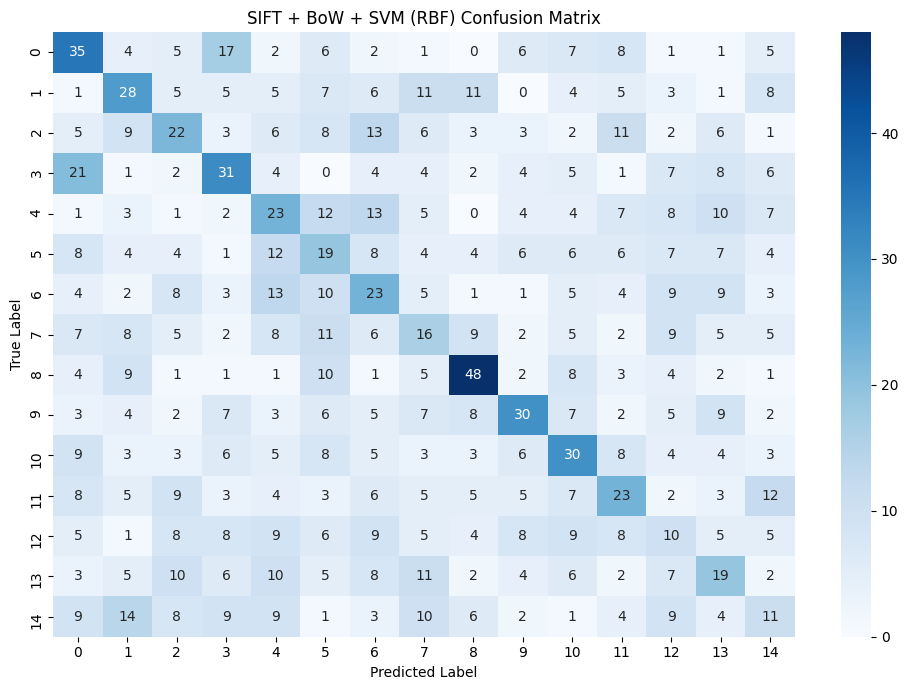


Saved outputs to:
 - /Users/maheshnilewar/Documents/Github/image_classification/results/metrics/sift_bow_svmrbf_k100_C10_gamma0p01_classification_report.txt
 - /Users/maheshnilewar/Documents/Github/image_classification/results/metrics/sift_bow_svmrbf_k100_C10_gamma0p01_summary.json
 - /Users/maheshnilewar/Documents/Github/image_classification/results/metrics/sift_bow_svmrbf_k100_C10_gamma0p01_confusion_matrix.csv
 - /Users/maheshnilewar/Documents/Github/image_classification/results/figures/sift_bow_svmrbf_k100_C10_gamma0p01_confusion_matrix.png


In [18]:
# =========================
# SIFT + BoW + SVM (RBF)
# Full pipeline with saving outputs to:
# /Users/maheshnilewar/Documents/Github/image_classification/results
# =========================

import os
import json
import cv2
import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


# --------- INPUT PATHS ----------
# output_path should contain: train/, test/, class_labels.txt
# Example:
# output_path = "/Users/maheshnilewar/Documents/Github/image_classification/dataset"

train_path = os.path.join(output_path, "train")
test_path  = os.path.join(output_path, "test")
class_labels_file = os.path.join(output_path, "class_labels.txt")

# --------- RESULTS PATHS (YOUR LOCATION) ----------
RESULTS_DIR = "/Users/maheshnilewar/Documents/Github/image_classification/results"
FIG_DIR = os.path.join(RESULTS_DIR, "figures")
METRICS_DIR = os.path.join(RESULTS_DIR, "metrics")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)


# --------- HELPERS ----------
def load_image_paths(folder_path, class_labels_file):
    """
    Returns:
      image_paths: list[str]
      labels: np.ndarray shape (N,)
      label_map: dict[class_name -> int]
    """
    image_paths, labels = [], []

    label_map = {}
    with open(class_labels_file, "r") as f:
        for line in f:
            class_name, label = line.strip().split(",")
            label_map[class_name] = int(label)

    # deterministic order by label
    for class_name, label in sorted(label_map.items(), key=lambda x: x[1]):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for img_name in os.listdir(class_folder):
            if img_name.startswith("."):
                continue
            img_path = os.path.join(class_folder, img_name)
            if img_path.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(img_path)
                labels.append(label)

    return image_paths, np.array(labels), label_map


def extract_sift_descriptors(image_paths):
    """
    Returns:
      descs_per_image: list of (np.ndarray [num_kp, 128] float32) OR None
    """
    sift = cv2.SIFT_create()
    descs_per_image = []

    for p in image_paths:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            descs_per_image.append(None)
            continue

        _, desc = sift.detectAndCompute(img, None)
        descs_per_image.append(desc)

    return descs_per_image


def fit_bow_kmeans(descs_per_image, num_clusters=100, random_state=42):
    """
    Fits a MiniBatchKMeans dictionary on training SIFT descriptors.
    """
    all_descs = [d for d in descs_per_image if d is not None and len(d) > 0]
    if len(all_descs) == 0:
        raise ValueError("No descriptors found. Check image paths or SIFT settings.")

    X = np.vstack(all_descs).astype(np.float32)

    kmeans = MiniBatchKMeans(
        n_clusters=num_clusters,
        random_state=random_state,
        batch_size=4096,
        n_init="auto"
    )
    kmeans.fit(X)
    return kmeans


def build_bow_features(descs_per_image, kmeans, num_clusters=100):
    """
    Converts descriptors for each image into a BoW histogram feature vector.
    Returns:
      X: np.ndarray shape (N, num_clusters)
    """
    X = np.zeros((len(descs_per_image), num_clusters), dtype=np.float32)

    for i, desc in enumerate(descs_per_image):
        if desc is None or len(desc) == 0:
            continue

        labels = kmeans.predict(desc.astype(np.float32))
        hist = np.bincount(labels, minlength=num_clusters).astype(np.float32)
        X[i] = hist

    # normalize histograms (usually helps)
    X = normalize(X, norm="l2")
    return X


# --------- RUN PIPELINE ----------
NUM_CLUSTERS = 100
RANDOM_STATE = 42

# Load image paths + labels
train_image_paths, y_train, label_map = load_image_paths(train_path, class_labels_file)
test_image_paths,  y_test,  _         = load_image_paths(test_path, class_labels_file)

print(f"Train images: {len(train_image_paths)} | Test images: {len(test_image_paths)}")
print(f"Num classes: {len(label_map)}")

# Extract SIFT descriptors (compute once)
train_descs = extract_sift_descriptors(train_image_paths)
test_descs  = extract_sift_descriptors(test_image_paths)

# Fit BoW dictionary on training descriptors
kmeans = fit_bow_kmeans(train_descs, num_clusters=NUM_CLUSTERS, random_state=RANDOM_STATE)

# Build BoW features
X_train = build_bow_features(train_descs, kmeans, num_clusters=NUM_CLUSTERS)
X_test  = build_bow_features(test_descs,  kmeans, num_clusters=NUM_CLUSTERS)

# Train SVM (RBF)
# NOTE: Do NOT scale twice. Use pipeline scaling only.
svm = make_pipeline(
    StandardScaler(with_mean=False),
    SVC(kernel="rbf", C=10, gamma=0.01)
)
svm.fit(X_train, y_train)
pred = svm.predict(X_test)

# Metrics
acc = accuracy_score(y_test, pred)
report = classification_report(y_test, pred, digits=4)
cm = confusion_matrix(y_test, pred)

print(report)
print("Accuracy:", acc)


# --------- SAVE OUTPUTS ----------
run_name = f"sift_bow_svmrbf_k{NUM_CLUSTERS}_C10_gamma0p01"

# 1) Report TXT
report_path = os.path.join(METRICS_DIR, f"{run_name}_classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)
    f.write("\n\nAccuracy: " + str(acc))

# 2) Summary JSON
summary = {
    "run_name": run_name,
    "method": "SIFT + Bag of Words + SVM (RBF)",
    "num_clusters": NUM_CLUSTERS,
    "svm_kernel": "rbf",
    "C": 10,
    "gamma": 0.01,
    "train_images": len(train_image_paths),
    "test_images": len(test_image_paths),
    "num_classes": len(label_map),
    "accuracy": float(acc),
    "random_state": RANDOM_STATE
}
summary_path = os.path.join(METRICS_DIR, f"{run_name}_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

# 3) Confusion matrix CSV
cm_csv_path = os.path.join(METRICS_DIR, f"{run_name}_confusion_matrix.csv")
np.savetxt(cm_csv_path, cm, delimiter=",")

# 4) Confusion matrix PNG
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("SIFT + BoW + SVM (RBF) Confusion Matrix")
plt.tight_layout()

fig_path = os.path.join(FIG_DIR, f"{run_name}_confusion_matrix.png")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print("\nSaved outputs to:")
print(" -", report_path)
print(" -", summary_path)
print(" -", cm_csv_path)
print(" -", fig_path)

Image classification using the Fisher Vector representation of ORB descriptors

SVM Classifier Performance:
              precision    recall  f1-score   support

           0       0.05      0.01      0.02       100
           1       0.03      0.01      0.02       100
           2       0.19      0.04      0.07       100
           3       0.08      0.89      0.14       100
           4       0.02      0.01      0.01       100
           5       0.10      0.03      0.05       100
           6       0.04      0.01      0.02       100
           7       0.00      0.00      0.00       100
           8       0.06      0.01      0.02       100
           9       0.17      0.07      0.10       100
          10       0.04      0.01      0.02       100
          11       0.04      0.01      0.02       100
          12       0.08      0.02      0.03       100
          13       0.11      0.02      0.03       100
          14       0.00      0.00      0.00       100

    accuracy                           0.08      1500
   macro avg       0.07      0.08      0.04      150

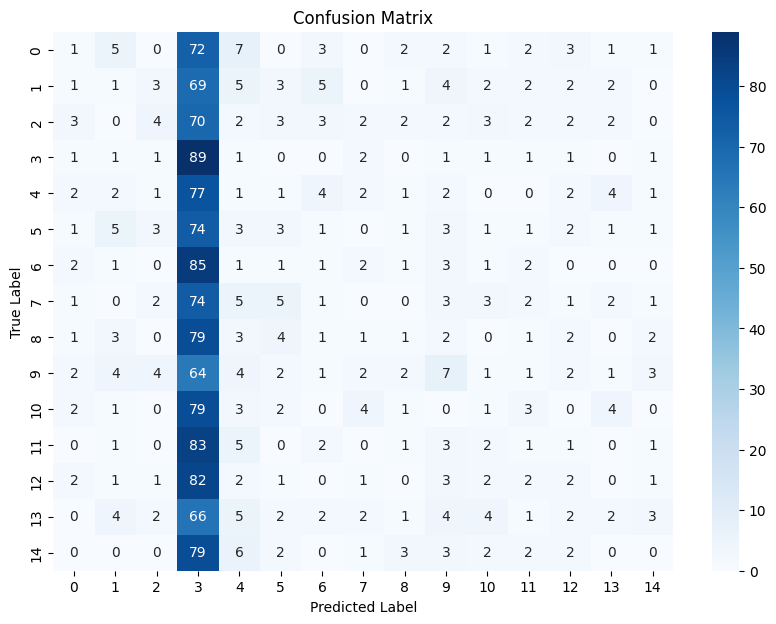

In [367]:
def load_images(folder_path, class_labels_file):
    images, labels, image_paths = [], [], []
    
    label_map = {}
    with open(class_labels_file, "r") as f:
        for line in f:
            class_name, label = line.strip().split(",")
            label_map[class_name] = int(label)
    
    for class_name, label in label_map.items():
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
                        image_paths.append(img_path)
    
    return images, np.array(labels), image_paths

# Extract ORB Features (instead of SIFT)
def extract_orb_features(image_paths):
    orb = cv2.ORB_create(nfeatures=500)  
    descriptor_list = []
    
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        keypoints, descriptors = orb.detectAndCompute(img, None)
        if descriptors is not None:
            descriptor_list.append(descriptors)

    return descriptor_list

# Train Gaussian Mixture Model (GMM)
def train_gmm(descriptor_list, num_clusters=64):
    if len(descriptor_list) == 0:
        raise ValueError("No ORB descriptors found. Cannot train GMM.")

    all_descriptors = np.vstack(descriptor_list)  # Stack all descriptors
    scaler = StandardScaler()
    all_descriptors = scaler.fit_transform(all_descriptors)  # Normalize features
    
    gmm = GaussianMixture(n_components=num_clusters, covariance_type='diag', random_state=42, max_iter=500, init_params='random_from_data')
    gmm.fit(all_descriptors)
    
    return gmm

# Compute Fisher Vector Encoding using ORB Descriptors
def fisher_vector_encoding(image_paths, gmm, num_clusters=64):
    orb = cv2.ORB_create(nfeatures=500)  # Adjust the number of features as needed
    feature_vectors = []
    
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        keypoints, descriptors = orb.detectAndCompute(img, None)
        if descriptors is not None:
            # Compute Fisher Vector Encoding
            probs = gmm.predict_proba(descriptors)
            means = (probs.T @ descriptors - gmm.means_) / np.sqrt(gmm.covariances_)
            covs = (probs.T @ (descriptors ** 2) - gmm.means_ ** 2 - gmm.covariances_) / np.sqrt(2 * gmm.covariances_)

            fisher_vector = np.hstack((means.flatten(), covs.flatten()))
            feature_vectors.append(fisher_vector)
        else:
            feature_vectors.append(np.zeros(num_clusters * 2 * 32))  

    return np.array(feature_vectors)

# Prepare Dataset Paths
output_path = "/Users/maheshnilewar/Documents/CV_Assignment"  
train_path = os.path.join(output_path, "train")
test_path = os.path.join(output_path, "test")
class_labels_file = os.path.join(output_path, "class_labels.txt")

# Load Images and Labels
train_images, train_labels, train_image_paths = load_images(train_path, class_labels_file)
test_images, test_labels, test_image_paths = load_images(test_path, class_labels_file)

# Extract ORB Descriptors
descriptor_list = extract_orb_features(train_image_paths)

# Train GMM 
num_clusters = 64  
gmm = train_gmm(descriptor_list, num_clusters=num_clusters)

# Compute Fisher Vector Encodings
X_train = fisher_vector_encoding(train_image_paths, gmm, num_clusters)
X_test = fisher_vector_encoding(test_image_paths, gmm, num_clusters)

# Standardization 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM Classifier
svm = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm.fit(X_train, train_labels)
predictions = svm.predict(X_test)

# Print Performance
print("SVM Classifier Performance:")
print(classification_report(test_labels, predictions))
print("Accuracy:", accuracy_score(test_labels, predictions))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(set(test_labels))), yticklabels=range(len(set(test_labels))))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Image classification using the Fisher Vector representation of SIFT descriptors

Train images: 6000 | Test images: 1500
Num classes: 15
              precision    recall  f1-score   support

           0     0.0556    0.0100    0.0169       100
           1     0.0870    0.0200    0.0325       100
           2     0.0455    0.0100    0.0164       100
           3     0.0000    0.0000    0.0000       100
           4     0.0833    0.0200    0.0323       100
           5     0.0714    0.0100    0.0175       100
           6     0.0741    0.0200    0.0315       100
           7     0.0000    0.0000    0.0000       100
           8     0.0000    0.0000    0.0000       100
           9     0.0714    0.0100    0.0175       100
          10     0.0689    0.8300    0.1272       100
          11     0.1379    0.0400    0.0620       100
          12     0.0667    0.0100    0.0174       100
          13     0.1111    0.0300    0.0472       100
          14     0.1034    0.0300    0.0465       100

    accuracy                         0.0693      1500
   macro avg     0.0651  

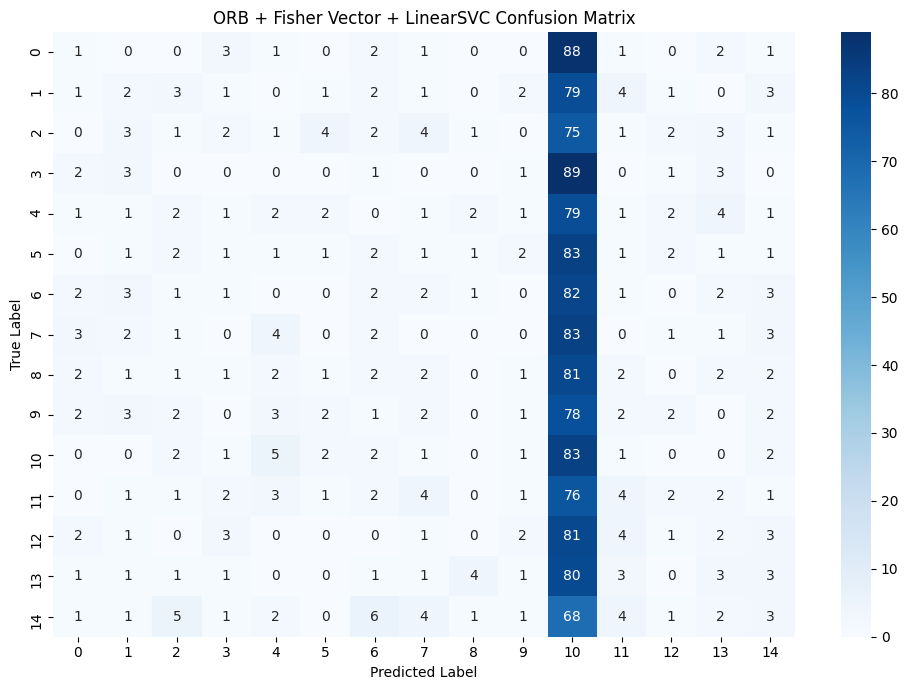


Saved outputs to:
 - /Users/maheshnilewar/Documents/Github/image_classification/results/metrics/orb_fisher_linearsvc_gmm64_nf500_classification_report.txt
 - /Users/maheshnilewar/Documents/Github/image_classification/results/metrics/orb_fisher_linearsvc_gmm64_nf500_summary.json
 - /Users/maheshnilewar/Documents/Github/image_classification/results/metrics/orb_fisher_linearsvc_gmm64_nf500_confusion_matrix.csv
 - /Users/maheshnilewar/Documents/Github/image_classification/results/figures/orb_fisher_linearsvc_gmm64_nf500_confusion_matrix.png


In [20]:
# ============================================
# ORB + Fisher Vector (GMM) + Linear SVM
# Saves outputs to: /Users/maheshnilewar/Documents/Github/image_classification/results
# ============================================

import os
import json
import cv2
import numpy as np

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


# ---------- SET THESE PATHS ----------
# This output_path must contain:
#   output_path/train/<class_name>/*.jpg
#   output_path/test/<class_name>/*.jpg
#   output_path/class_labels.txt
#
# Example:
# output_path = "/Users/maheshnilewar/Documents/Github/image_classification/dataset"
#
# NOTE: In your snippet you used "/Users/maheshnilewar/Documents/CV_Assignment"
# Only keep ONE correct path.

# output_path = "/Users/maheshnilewar/Documents/CV_Assignment"   # <-- if this is the correct one
train_path = os.path.join(output_path, "train")
test_path  = os.path.join(output_path, "test")
class_labels_file = os.path.join(output_path, "class_labels.txt")

# Results location (your provided path)
RESULTS_DIR = "/Users/maheshnilewar/Documents/Github/image_classification/results"
FIG_DIR = os.path.join(RESULTS_DIR, "figures")
METRICS_DIR = os.path.join(RESULTS_DIR, "metrics")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)


# ---------- HELPERS ----------
def load_image_paths(folder_path, class_labels_file):
    """Return image_paths, labels, label_map"""
    image_paths, labels = [], []

    label_map = {}
    with open(class_labels_file, "r") as f:
        for line in f:
            class_name, label = line.strip().split(",")
            label_map[class_name] = int(label)

    # deterministic order by label id
    for class_name, label in sorted(label_map.items(), key=lambda x: x[1]):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for img_name in os.listdir(class_folder):
            if img_name.startswith("."):
                continue
            img_path = os.path.join(class_folder, img_name)
            if img_path.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(img_path)
                labels.append(label)

    return image_paths, np.array(labels), label_map


def extract_orb_descs_per_image(image_paths, nfeatures=500):
    """
    Returns list of descriptors per image.
    Each element: (n_kp, 32) uint8 OR None
    """
    orb = cv2.ORB_create(nfeatures=nfeatures)
    descs = []

    for p in image_paths:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            descs.append(None)
            continue
        _, d = orb.detectAndCompute(img, None)
        descs.append(d)

    return descs


def fit_scaler_and_gmm(train_descs_per_image, num_components=64, random_state=42):
    """
    Fits StandardScaler + GMM on stacked training descriptors.
    Returns (scaler, gmm, descriptor_dim)
    """
    all_descs = [d for d in train_descs_per_image if d is not None and len(d) > 0]
    if len(all_descs) == 0:
        raise ValueError("No ORB descriptors found in training set. Check data/paths.")

    X = np.vstack(all_descs).astype(np.float32)  # ORB is uint8 -> float for GMM
    D = X.shape[1]  # should be 32 for ORB

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    gmm = GaussianMixture(
        n_components=num_components,
        covariance_type="diag",
        random_state=random_state,
        max_iter=500,
        init_params="kmeans"
    )
    gmm.fit(Xs)
    return scaler, gmm, D


def fisher_vector_from_desc(desc, scaler, gmm):
    """
    Compute Fisher Vector (means + variances gradients) for one image.
    - desc: (T, D) uint8/float
    Returns fv: shape (2*K*D,)
    """
    K = gmm.n_components
    if desc is None or len(desc) == 0:
        # FV length = 2*K*D
        D = gmm.means_.shape[1]
        return np.zeros(2 * K * D, dtype=np.float32)

    x = desc.astype(np.float32)
    x = scaler.transform(x)  # IMPORTANT: same scaler used for training GMM

    # Responsibilities: (T, K)
    q = gmm.predict_proba(x)

    w = gmm.weights_          # (K,)
    mu = gmm.means_           # (K, D)
    var = gmm.covariances_    # (K, D) diag variances
    sigma = np.sqrt(var)      # (K, D)

    # Sufficient statistics
    # N: (K,)
    N = q.sum(axis=0) + 1e-12
    # S: (K, D)
    S = q.T @ x
    # S2: (K, D)
    S2 = q.T @ (x * x)

    # Gradients w.r.t means and variances (common FV form, diag cov)
    # u_kd
    u = (S - N[:, None] * mu) / (np.sqrt(w)[:, None] * sigma)
    # v_kd
    v = (S2 - 2 * mu * S + N[:, None] * (mu * mu - var)) / (np.sqrt(2 * w)[:, None] * var)

    fv = np.hstack([u.flatten(), v.flatten()]).astype(np.float32)

    # Power normalization then L2 normalization (standard for FV)
    fv = np.sign(fv) * np.sqrt(np.abs(fv) + 1e-12)
    fv_norm = np.linalg.norm(fv) + 1e-12
    fv = fv / fv_norm

    return fv


def fisher_vectors_for_images(descs_per_image, scaler, gmm):
    """Build FV matrix X: (N, 2*K*D)"""
    X = np.vstack([fisher_vector_from_desc(d, scaler, gmm) for d in descs_per_image])
    return X


# ---------- RUN PIPELINE ----------
NUM_COMPONENTS = 64
ORB_NFEATURES = 500
RANDOM_STATE = 42

train_image_paths, y_train, label_map = load_image_paths(train_path, class_labels_file)
test_image_paths,  y_test,  _         = load_image_paths(test_path, class_labels_file)

print(f"Train images: {len(train_image_paths)} | Test images: {len(test_image_paths)}")
print(f"Num classes: {len(label_map)}")

train_descs = extract_orb_descs_per_image(train_image_paths, nfeatures=ORB_NFEATURES)
test_descs  = extract_orb_descs_per_image(test_image_paths,  nfeatures=ORB_NFEATURES)

scaler_desc, gmm, D = fit_scaler_and_gmm(train_descs, num_components=NUM_COMPONENTS, random_state=RANDOM_STATE)

X_train = fisher_vectors_for_images(train_descs, scaler_desc, gmm)
X_test  = fisher_vectors_for_images(test_descs,  scaler_desc, gmm)

# Linear SVM on FV
# (FV is already normalized; this works well)
clf = LinearSVC(random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

acc = accuracy_score(y_test, pred)
report = classification_report(y_test, pred, digits=4)
cm = confusion_matrix(y_test, pred)

print(report)
print("Accuracy:", acc)


# ---------- SAVE OUTPUTS ----------
run_name = f"orb_fisher_linearsvc_gmm{NUM_COMPONENTS}_nf{ORB_NFEATURES}"

# 1) Report TXT
report_path = os.path.join(METRICS_DIR, f"{run_name}_classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)
    f.write("\n\nAccuracy: " + str(acc))

# 2) Summary JSON
summary = {
    "run_name": run_name,
    "method": "ORB + Fisher Vector (GMM diag) + LinearSVC",
    "gmm_components": NUM_COMPONENTS,
    "orb_nfeatures": ORB_NFEATURES,
    "descriptor_dim": int(D),
    "train_images": int(len(train_image_paths)),
    "test_images": int(len(test_image_paths)),
    "num_classes": int(len(label_map)),
    "accuracy": float(acc),
    "random_state": RANDOM_STATE
}
summary_path = os.path.join(METRICS_DIR, f"{run_name}_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

# 3) Confusion matrix CSV
cm_csv_path = os.path.join(METRICS_DIR, f"{run_name}_confusion_matrix.csv")
np.savetxt(cm_csv_path, cm, delimiter=",")

# 4) Confusion matrix PNG
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("ORB + Fisher Vector + LinearSVC Confusion Matrix")
plt.tight_layout()

fig_path = os.path.join(FIG_DIR, f"{run_name}_confusion_matrix.png")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print("\nSaved outputs to:")
print(" -", report_path)
print(" -", summary_path)
print(" -", cm_csv_path)
print(" -", fig_path)

Train: (6000, 4096) (6000, 15)
Test : (1500, 4096) (1500, 15)
Train label counts: [400 400 400 400 400 400 400 400 400 400 400 400 400 400 400]
Test  label counts: [100 100 100 100 100 100 100 100 100 100 100 100 100 100 100]
Max y_train: 14 Max y_test: 14
Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,267,407 (8.65 MB)

 Trainable params: 2,265,615 (8.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1461 - loss: 3.0718 - val_accuracy: 0.0000e+00 - val_loss: 4.0367
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2016 - loss: 2.5247 - val_accuracy: 0.0000e+00 - val_loss: 4.3798
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2405 - loss: 2.3727 - val_accuracy: 0.0000e+00 - val_loss: 4.8930
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2598 - loss: 2.2669 - val_accuracy: 0.0000e+00 - val_loss: 5.2753
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2941 - loss: 2.1860 - val_accuracy: 0.0000e+00 - val_loss: 6.1628
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2966 - loss: 2.1142 - val_accuracy: 0.0000e+00 - val_loss: 5.9321
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3063 - loss: 2.0954 - val_accuracy: 0.0000e+00 - val_loss: 6.2543
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3006 - los

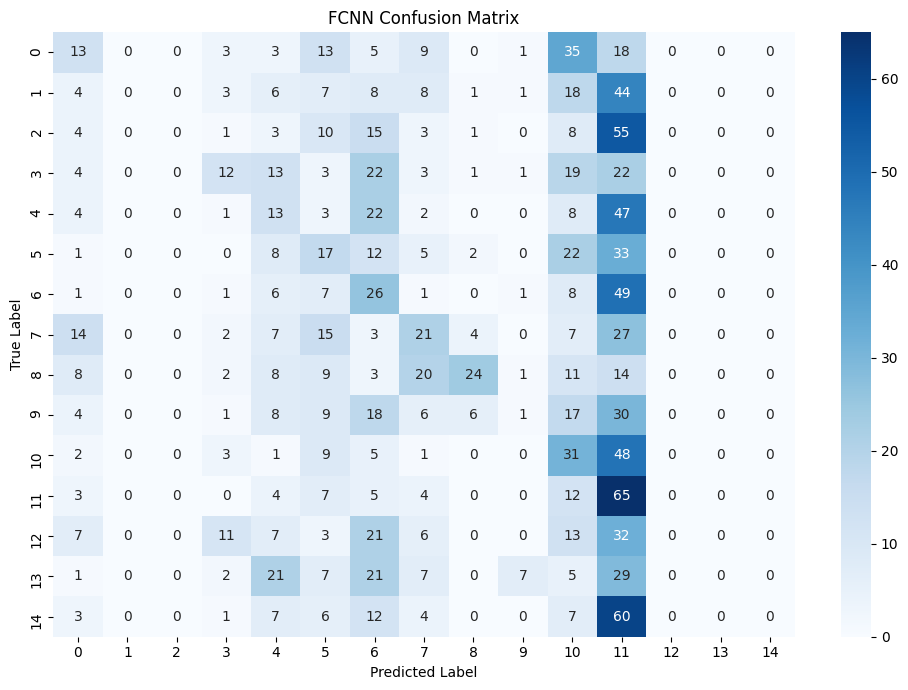

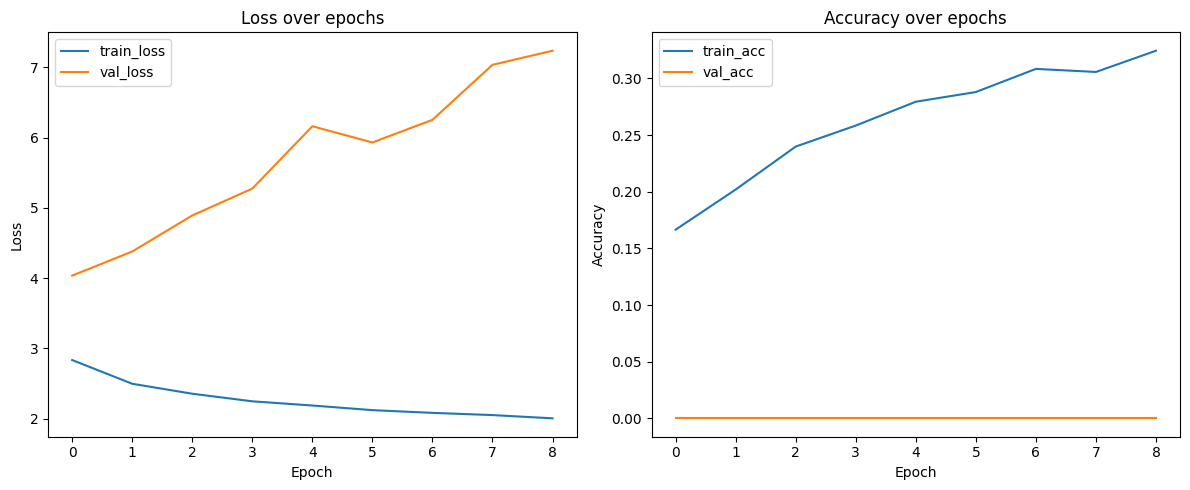


Saved outputs to:
 - Model (best): /Users/maheshnilewar/Documents/Github/image_classification/results/models/fcnn_bn_dropout025_valsplit_classweights.keras
 - Weights: /Users/maheshnilewar/Documents/Github/image_classification/results/models/fcnn_bn_dropout025_valsplit_classweights.weights.h5
 - Report: /Users/maheshnilewar/Documents/Github/image_classification/results/metrics/fcnn_bn_dropout025_valsplit_classweights_classification_report.txt
 - Summary: /Users/maheshnilewar/Documents/Github/image_classification/results/metrics/fcnn_bn_dropout025_valsplit_classweights_summary.json
 - Confusion CSV: /Users/maheshnilewar/Documents/Github/image_classification/results/metrics/fcnn_bn_dropout025_valsplit_classweights_confusion_matrix.csv
 - Confusion PNG: /Users/maheshnilewar/Documents/Github/image_classification/results/figures/fcnn_bn_dropout025_valsplit_classweights_confusion_matrix.png
 - Curves PNG: /Users/maheshnilewar/Documents/Github/image_classification/results/figures/fcnn_bn_dro

In [32]:
# ============================================
# FCNN Baseline (Keras) for 15-class classification
# - Balanced dataset (400 train / 100 test per class)
# - Fixes "class collapse" as much as possible:
#     * BatchNorm
#     * Dropout reduced to 0.25
#     * validation_split (do NOT use test as validation)
#     * optional class_weight (enabled below)
# ============================================

import os
import json
import random
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# ---------- Reproducibility ----------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# ---------- PATHS ----------
# output_path must contain:
#   output_path/train/<class_name>/*.jpg
#   output_path/test/<class_name>/*.jpg
#   output_path/class_labels.txt
#
# Example:
# output_path = "/Users/maheshnilewar/Documents/Github/image_classification/dataset"

train_path = os.path.join(output_path, "train")
test_path  = os.path.join(output_path, "test")
class_labels_file = os.path.join(output_path, "class_labels.txt")

RESULTS_DIR = "/Users/maheshnilewar/Documents/Github/image_classification/results"
FIG_DIR = os.path.join(RESULTS_DIR, "figures")
METRICS_DIR = os.path.join(RESULTS_DIR, "metrics")
MODELS_DIR = os.path.join(RESULTS_DIR, "models")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)


# ---------- Data Loading ----------
def load_images(folder_path, class_labels_file):
    """
    Loads grayscale images using class_labels.txt mapping.
    Returns:
      images: list[np.ndarray]
      labels: np.ndarray (N,)
      label_map: dict[class_name -> int]
    """
    images, labels = [], []

    label_map = {}
    with open(class_labels_file, "r") as f:
        for line in f:
            class_name, label = line.strip().split(",")
            label_map[class_name] = int(label)

    # deterministic order by label
    for class_name, label in sorted(label_map.items(), key=lambda x: x[1]):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for img_name in os.listdir(class_folder):
            if img_name.startswith("."):  # ignore macOS hidden files
                continue
            img_path = os.path.join(class_folder, img_name)
            if img_path.lower().endswith((".jpg", ".jpeg", ".png")):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    labels.append(label)

    return images, np.array(labels), label_map


def preprocess_images(images, target_size=(64, 64)):
    processed = []
    for img in images:
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        img_norm = img_resized.astype(np.float32) / 255.0
        processed.append(img_norm)
    return np.array(processed, dtype=np.float32)


# ---------- Load & Preprocess ----------
train_imgs, y_train, label_map = load_images(train_path, class_labels_file)
test_imgs,  y_test,  _         = load_images(test_path, class_labels_file)

num_classes = len(label_map)
assert num_classes == 15, f"Expected 15 classes, found {num_classes}"

X_train = preprocess_images(train_imgs, target_size=(64, 64))
X_test  = preprocess_images(test_imgs,  target_size=(64, 64))

# Flatten for FCNN
X_train = X_train.reshape((-1, 64 * 64))
X_test  = X_test.reshape((-1, 64 * 64))

# One-hot encode labels
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_test_oh  = to_categorical(y_test,  num_classes=num_classes)

print("Train:", X_train.shape, y_train_oh.shape)
print("Test :", X_test.shape,  y_test_oh.shape)

# Sanity check: balanced counts
print("Train label counts:", np.bincount(y_train, minlength=num_classes))
print("Test  label counts:", np.bincount(y_test, minlength=num_classes))
print("Max y_train:", y_train.max(), "Max y_test:", y_test.max())


# ---------- Model ----------
def create_fcnn_model(input_dim=64*64, num_classes=15, dropout=0.25):
    model = Sequential([
        Dense(512, input_dim=input_dim, activation="relu"),
        BatchNormalization(),
        Dropout(dropout),

        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(dropout),

        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(dropout),

        Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# ---------- Training config ----------
run_name = "fcnn_bn_dropout025_valsplit_classweights"
model_path = os.path.join(MODELS_DIR, f"{run_name}.keras")
weights_path = os.path.join(MODELS_DIR, f"{run_name}.weights.h5")

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, monitor="val_accuracy", save_best_only=True)
]

# Optional: Class weights (helps stop predicting only a few classes)
class_w = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=y_train
)
class_w = {i: float(w) for i, w in enumerate(class_w)}
print("Class weights:", class_w)

model = create_fcnn_model(input_dim=64*64, num_classes=num_classes, dropout=0.25)
model.summary()

history = model.fit(
    X_train, y_train_oh,
    validation_split=0.2,          # IMPORTANT: keep test set for final evaluation only
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_w,          # you can remove this line if you don't want class weights
    verbose=1
)

# Save final weights too
model.save_weights(weights_path)


# ---------- Evaluate on Test Set ----------
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
print(f"Test accuracy (Keras): {test_acc*100:.2f}% | Test loss: {test_loss:.4f}")

probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(probs, axis=1)

acc_sklearn = accuracy_score(y_test, y_pred)
print("Accuracy (sklearn):", acc_sklearn)

# Show predicted distribution (useful diagnostic)
print("Predicted class counts:", np.bincount(y_pred, minlength=num_classes))
missing = np.where(np.bincount(y_pred, minlength=num_classes) == 0)[0]
print("Never predicted labels:", missing)

inv_map = {v: k for k, v in label_map.items()}
print("Never predicted class names:", [inv_map[i] for i in missing if i in inv_map])

report = classification_report(y_test, y_pred, digits=4, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("\nClassification report:\n", report)


# ---------- Save metrics ----------
report_path = os.path.join(METRICS_DIR, f"{run_name}_classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)
    f.write(f"\n\nKeras test_acc: {test_acc}\nKeras test_loss: {test_loss}\nSklearn accuracy: {acc_sklearn}\n")
    f.write("\nNever predicted labels: " + np.array2string(missing) + "\n")
    f.write("Never predicted class names: " + str([inv_map[i] for i in missing if i in inv_map]) + "\n")

summary = {
    "run_name": run_name,
    "model": "FCNN (Dense) with BatchNorm + Dropout",
    "input": "64x64 grayscale flattened",
    "num_classes": int(num_classes),
    "train_samples": int(X_train.shape[0]),
    "test_samples": int(X_test.shape[0]),
    "epochs_ran": int(len(history.history["loss"])),
    "dropout": 0.25,
    "validation_split": 0.2,
    "class_weight_used": True,
    "test_accuracy_keras": float(test_acc),
    "test_loss_keras": float(test_loss),
    "test_accuracy_sklearn": float(acc_sklearn),
    "never_predicted_labels": missing.tolist(),
    "never_predicted_class_names": [inv_map[i] for i in missing if i in inv_map],
    "seed": SEED,
    "saved_model_path": model_path,
    "saved_weights_path": weights_path
}
summary_path = os.path.join(METRICS_DIR, f"{run_name}_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

cm_csv_path = os.path.join(METRICS_DIR, f"{run_name}_confusion_matrix.csv")
np.savetxt(cm_csv_path, cm, delimiter=",")


# ---------- Save figures ----------
# Confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("FCNN Confusion Matrix")
plt.tight_layout()
cm_fig_path = os.path.join(FIG_DIR, f"{run_name}_confusion_matrix.png")
plt.savefig(cm_fig_path, dpi=300, bbox_inches="tight")
plt.show()

# Training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
curves_path = os.path.join(FIG_DIR, f"{run_name}_training_curves.png")
plt.savefig(curves_path, dpi=300, bbox_inches="tight")
plt.show()

print("\nSaved outputs to:")
print(" - Model (best):", model_path)
print(" - Weights:", weights_path)
print(" - Report:", report_path)
print(" - Summary:", summary_path)
print(" - Confusion CSV:", cm_csv_path)
print(" - Confusion PNG:", cm_fig_path)
print(" - Curves PNG:", curves_path)